In [59]:
cd /data/convchess/src/play/

/data/convchess/src/play


In [2]:
import keras
import cPickle as pkl
import sys
import numpy as np
sys.setrecursionlimit(40000)
class CNN_evaluator:
	"""docstring for CNN_evaluation"""
	def __init__(self, model_file):
		self.model = pkl.load(open(model_file, 'r'))

	def evaluate(self, im):
		return self.model.predict(np.asarray([im]), verbose=0)[0][0]

	def evaluate_batch(self, batch):
		#batch is much faster than one individually
		#print batch
		return self.model.predict(np.asarray(batch), verbose=0, batch_size=1024)[:,0]

In [67]:
evaluator = CNN_evaluator('regression_models/model_g07_all_large_deep_do_2.pkl')

In [4]:
from play4 import *

In [5]:
import sunfish
pos = sunfish.Position(sunfish.initial, 0, (True,True), (True,True), 0, 0)
bb = pos_board_to_bitboard(pos.board)
print bb
im = convert_bitboard_to_image(bb)
im = np.rollaxis(im, 2, 0)
print im

r n b q k b n r 
p p p p p p p p 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
. . . . . . . . 
P P P P P P P P 
R N B Q K B N R
[[[ 0.  0.  0.  0.  0.  0.  0.  0.]
  [-1. -1. -1. -1. -1. -1. -1. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  1.  1.  1.  1.  1.  1.  1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]]

 [[-1.  0.  0.  0.  0.  0.  0. -1.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 1.  0.  0.  0.  0.  0.  0.  1.]]

 [[ 0. -1.  0.  0.  0.  0. -1.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  0.  0.  0.  0.  0.  0.  0.]
  [ 0.  1.  0.  0.  0.  0.  1.  0

In [6]:
evaluator.evaluate(im)

-0.0073839221149682999

In [7]:
from example_moves.draw_board.draw import *

In [8]:
cd example_moves/draw_board/

/data/convchess/src/util/draw_board


In [20]:
def parseFEN(fen):
	""" Parses a string in Forsyth-Edwards Notation into a Position """
	board, color, castling, enpas, hclock, fclock = fen.split()
	board = re.sub('\d', (lambda m: '.'*int(m.group(0))), board)
	board = ' '*19+'\n ' + '\n '.join(board.split('/')) + ' \n'+' '*19
	wc = ('Q' in castling, 'K' in castling)
	bc = ('k' in castling, 'q' in castling)
	ep = sunfish.parse(enpas) if enpas != '-' else 0
	score = sum(sunfish.pst[p][i] for i,p in enumerate(board) if p.isupper())
	score -= sum(sunfish.pst[p.upper()][i] for i,p in enumerate(board) if p.islower())
	pos = sunfish.Position(board, score, wc, bc, ep, 0)
	return pos if color == 'w' else pos.rotate()
def posboard_to_im(pos):
    bb = pos_board_to_bitboard(pos)
    im = convert_bitboard_to_image(bb)
    im = np.rollaxis(im,2,0)
    return im
def fen_to_im(fen):
    pos = parseFEN(fen)
    return posboard_to_im(pos.board)
def image_board(pos):
    plt.xticks(range(8), string.lowercase)
    ax = plt.imshow(draw_board(posboard_to_im(pos)), cmap=cm.Greys_r)
    f = plt.gcf()
    f.set_size_inches(6,6)
    ax.set_extent([-0.5,7.5,0.5,8.5])
    plt.show()

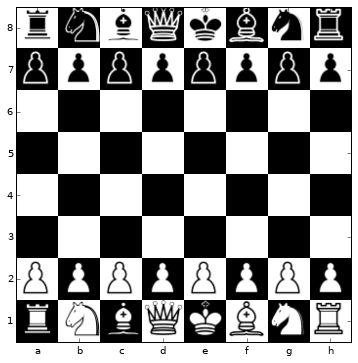

In [21]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.cm as cm
image_board(pos.board)

In [23]:
def top_bottom_moves(fen, top=5, bottom=5):
    pos = parseFEN(fen)
    bb = pos_board_to_bitboard(pos.board)
    image_board(pos.board)
    im = convert_bitboard_to_image(bb)
    im = np.rollaxis(im, 2, 0)
    print "\tCurrent evaluation: %f"%evaluator.evaluate(im)
    future_boards = []
    pos_children = []
    moves = list(pos.genMoves())
    print "Total %d moves possible"%len(moves)
    for move in moves:
        pos_child = pos.move(move).rotate()
        bb = pos_board_to_bitboard(pos_child.board)
        im = convert_bitboard_to_image(bb)
        im = np.rollaxis(im, 2, 0)
        future_boards.append(im)
        pos_children.append(pos_child.board)
    #future_boards = np.asarray(future_boards)
    values = evaluator.evaluate_batch(future_boards)
    poschildren_vals = sorted(zip(pos_children , moves, values), key=operator.itemgetter(2), reverse=True)
    print "TOP 5 Moves"
    for pos_child, move, value in poschildren_vals[0:top]:
        image_board(pos_child)
        print '\t',sunfish.render(move[0]) + sunfish.render(move[1]), value 
    print "WORST 5 Moves"
    for pos_child, move, value in poschildren_vals[-bottom:]:
        image_board(pos_child)
        print '\t',sunfish.render(move[0]) + sunfish.render(move[1]), value 

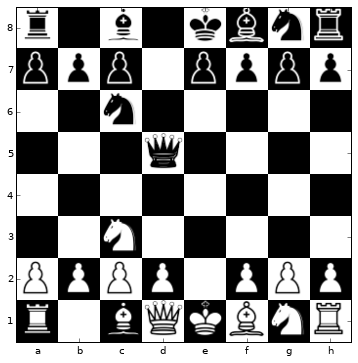

	Current evaluation: -0.007801
Total 32 moves possible
TOP 5 Moves


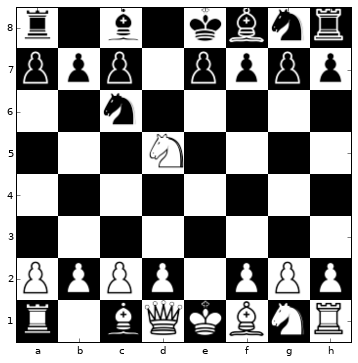

	c3d5 0.0391995124519


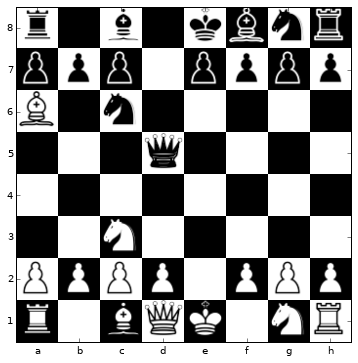

	f1a6 -0.00209638359956


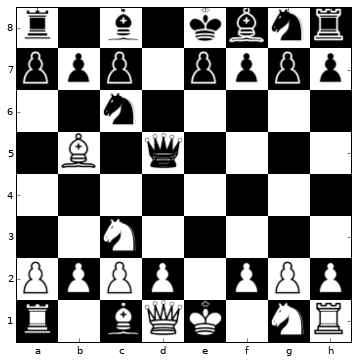

	f1b5 -0.00364469620399


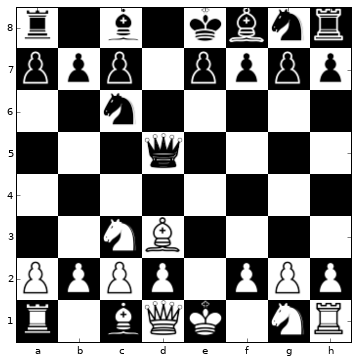

	f1d3 -0.00367119186558


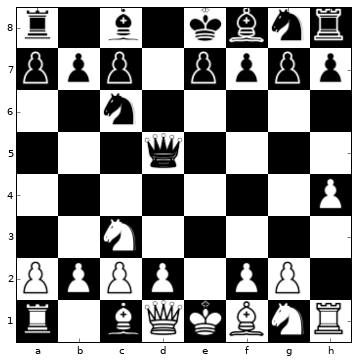

	h2h4 -0.00387797062285
WORST 5 Moves


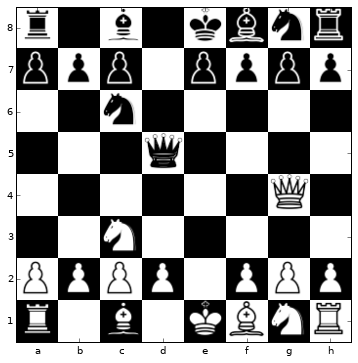

	d1g4 -0.0102297039703


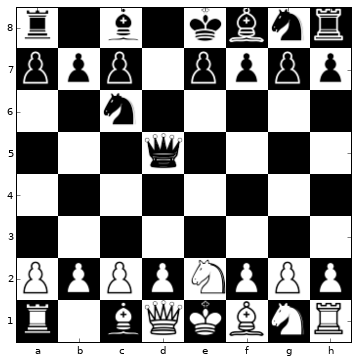

	c3e2 -0.0117464866489


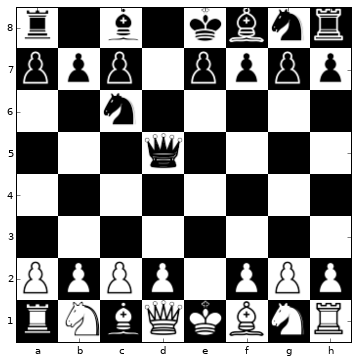

	c3b1 -0.0118463495746


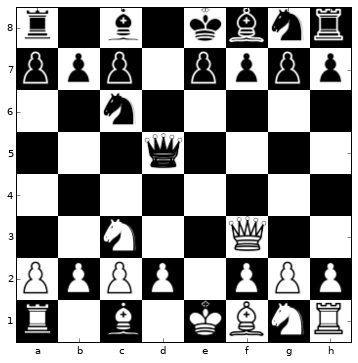

	d1f3 -0.0142719065771


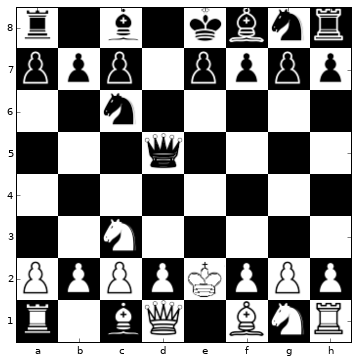

	e1e2 -0.0171070154756


In [24]:
'''
Killing Queen with a knight
(Works)
'''
top_bottom_moves('r1b1kbnr/ppp1pppp/2n5/3q4/8/2N5/PPPP1PPP/R1BQKBNR w KQkq - 0 4')

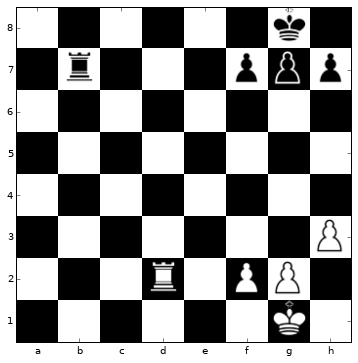

	Current evaluation: 0.001091
Total 19 moves possible
TOP 5 Moves


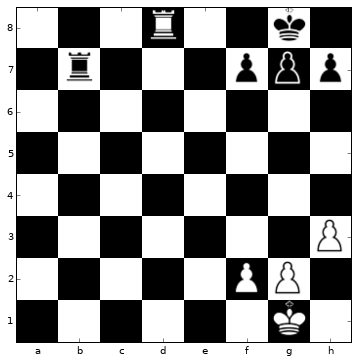

	d2d8 0.0118363378569


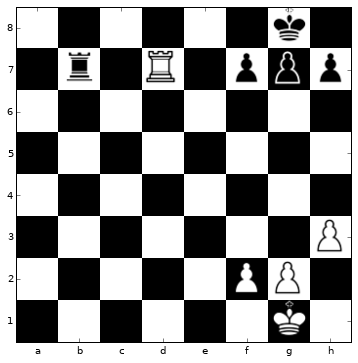

	d2d7 0.00984750129282


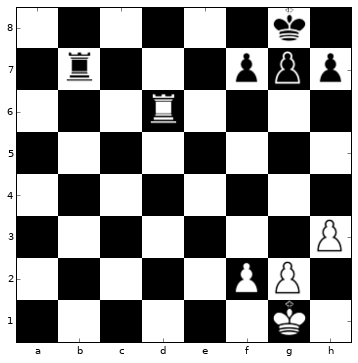

	d2d6 0.00372869847342


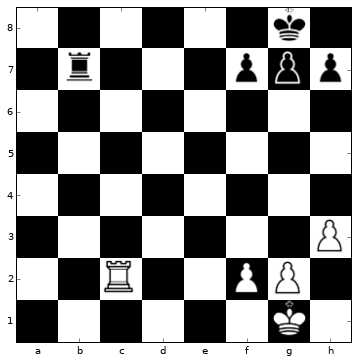

	d2c2 0.0031042911578


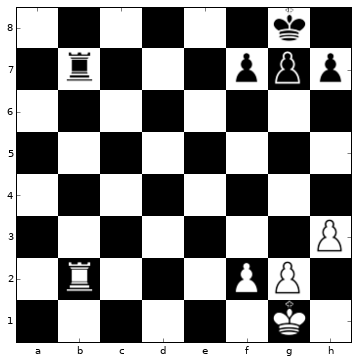

	d2b2 0.00227224244736
WORST 5 Moves


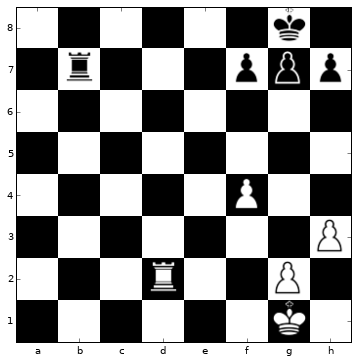

	f2f4 -0.00233094161376


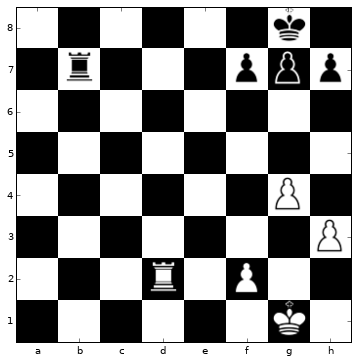

	g2g4 -0.0025795137044


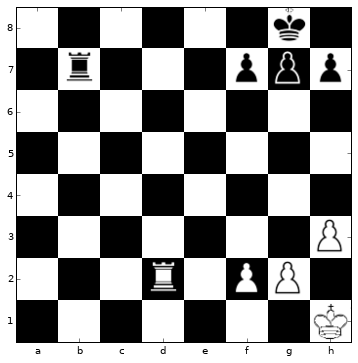

	g1h1 -0.00321029894985


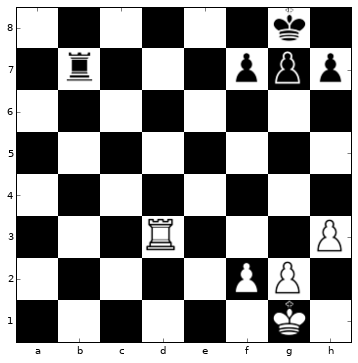

	d2d3 -0.00345524330623


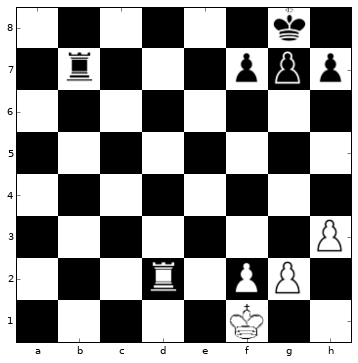

	g1f1 -0.00889493525028


In [25]:
'''
Checkmating with a rook
(Works)
'''
top_bottom_moves('6k1/1r3ppp/8/8/8/7P/3R1PP1/6K1 w - - 0 0')

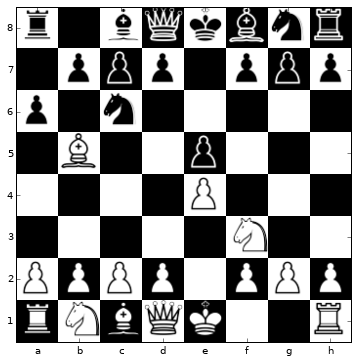

	Current evaluation: -0.003178
Total 32 moves possible
TOP 5 Moves


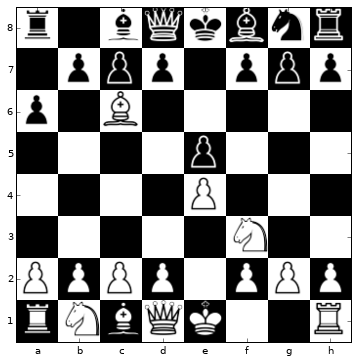

	b5c6 0.00882371887565


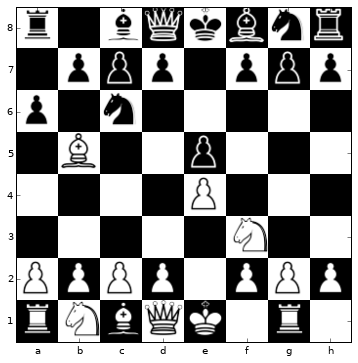

	h1g1 0.00568593852222


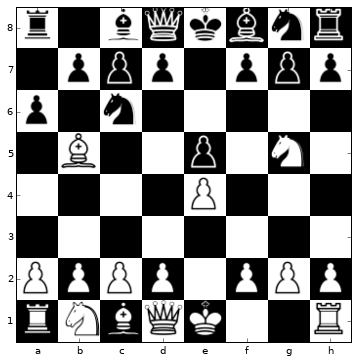

	f3g5 0.0055744452402


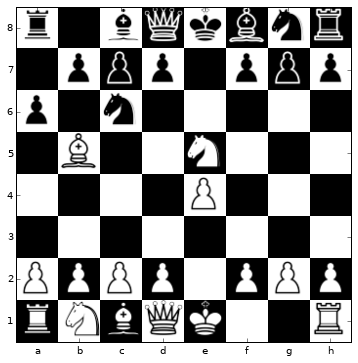

	f3e5 0.00489227008075


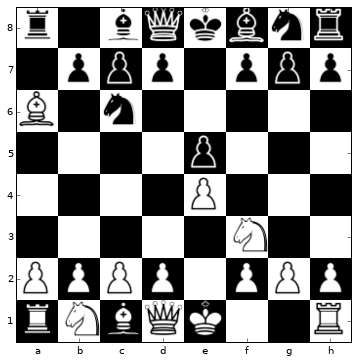

	b5a6 0.0020830060821
WORST 5 Moves


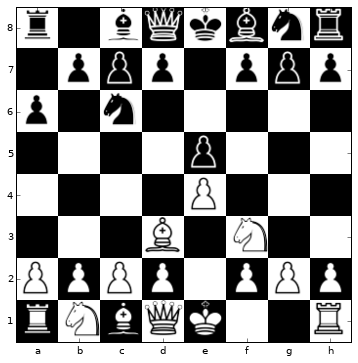

	b5d3 -0.00543896341696


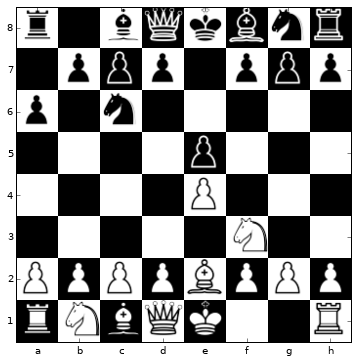

	b5e2 -0.00623718183488


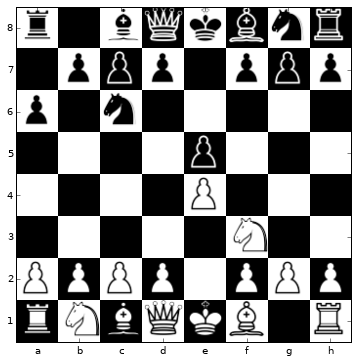

	b5f1 -0.00895959790796


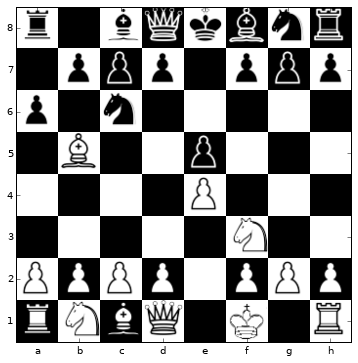

	e1f1 -0.00983993429691


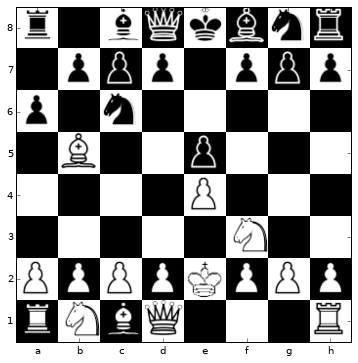

	e1e2 -0.0115267653018


In [26]:
'''
 Trading the knight with a bishop
'''
top_bottom_moves('r1bqkbnr/1ppp1ppp/p1n5/1B2p3/4P3/5N2/PPPP1PPP/RNBQK2R w KQkq - 0 0')

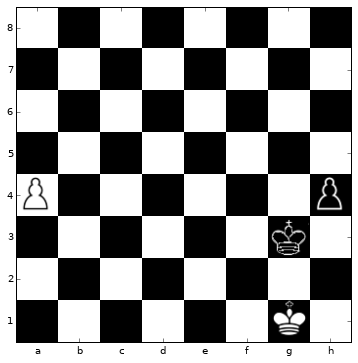

	Current evaluation: -0.024319
Total 6 moves possible
TOP 5 Moves


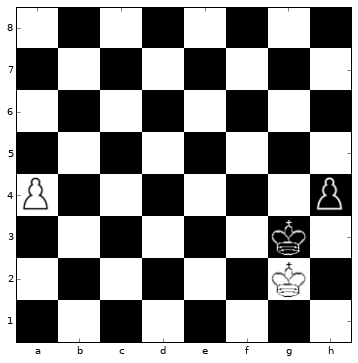

	g1g2 -0.00934144854546


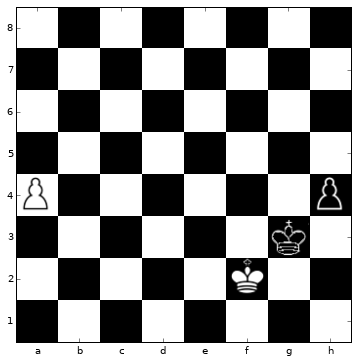

	g1f2 -0.0107374908403


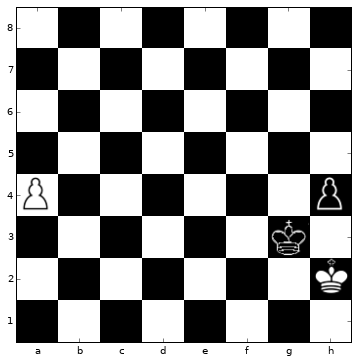

	g1h2 -0.0180687885731


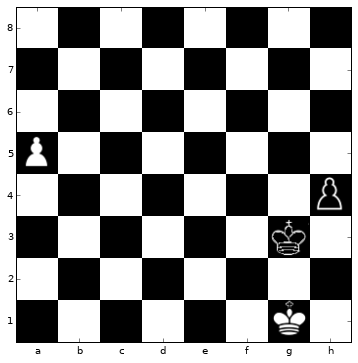

	a4a5 -0.0245109852403


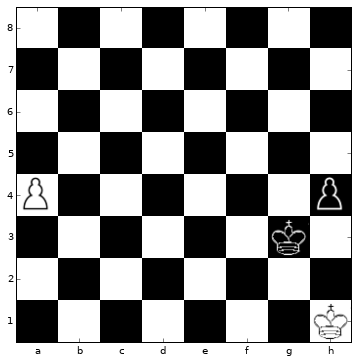

	g1h1 -0.0268974322826
WORST 5 Moves


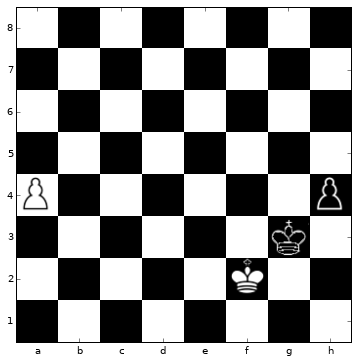

	g1f2 -0.0107374908403


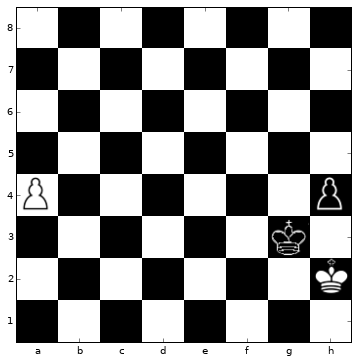

	g1h2 -0.0180687885731


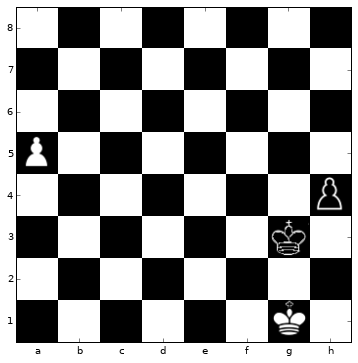

	a4a5 -0.0245109852403


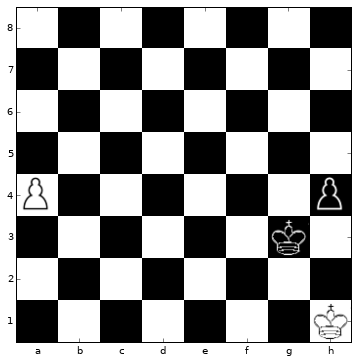

	g1h1 -0.0268974322826


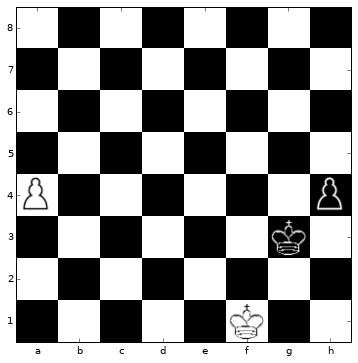

	g1f1 -0.0360509380698


In [27]:
'''
Runaway Pawn
'''
top_bottom_moves('8/8/8/8/P6p/6k1/8/6K1 w - - 0 0')

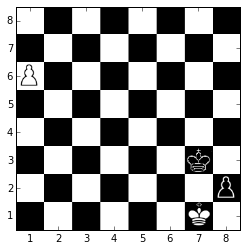

	Current evaluation: 0.069715
TOP 5 Moves


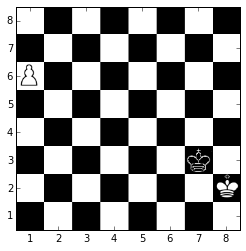

	g1h2 0.113119147718


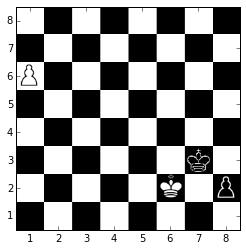

	g1f2 0.0845530852675


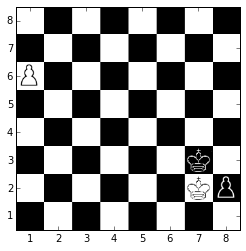

	g1g2 0.0727126449347


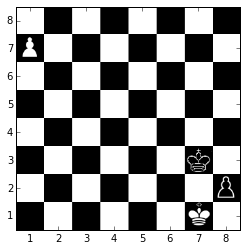

	a6a7 0.0677114725113


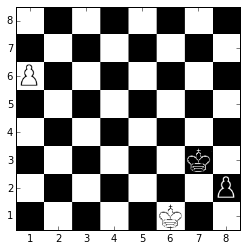

	g1f1 0.0593221075833
WORST 5 Moves


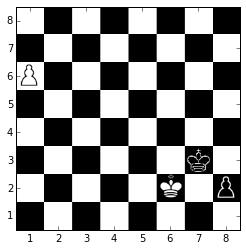

	g1f2 0.0845530852675


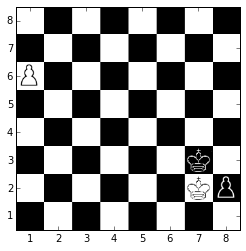

	g1g2 0.0727126449347


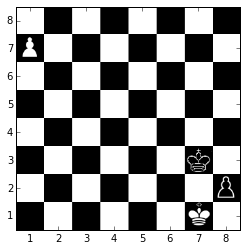

	a6a7 0.0677114725113


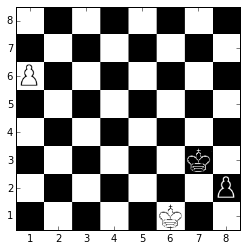

	g1f1 0.0593221075833


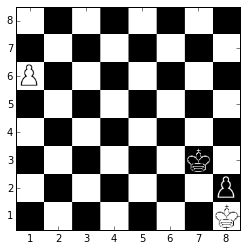

	g1h1 0.0573387891054


In [117]:
'''
Check and Blocking a promotion
'''
fen = '8/8/P7/8/8/6k1/7p/6K1 w - - 0 0'
top_bottom_moves(fen)

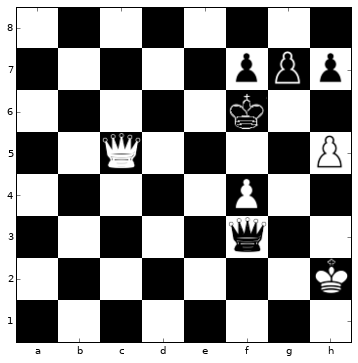

	Current evaluation: -0.015590
Total 31 moves possible
TOP 5 Moves


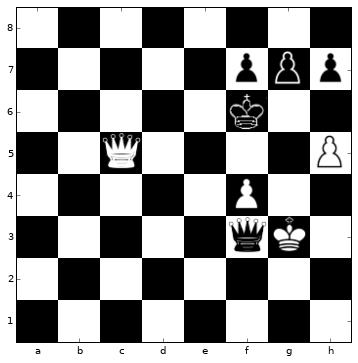

	h2g3 0.00246483809315


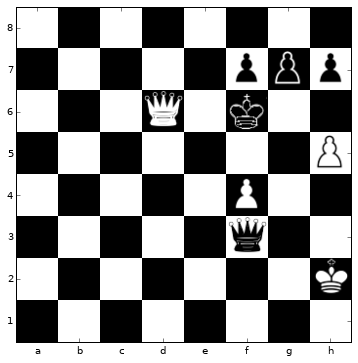

	c5d6 -0.00684824865311


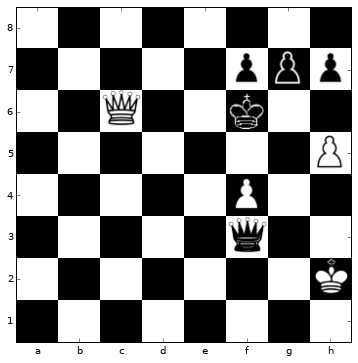

	c5c6 -0.00850074365735


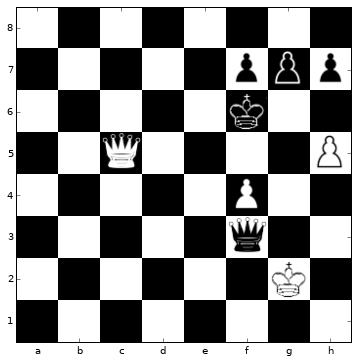

	h2g2 -0.00893254112452


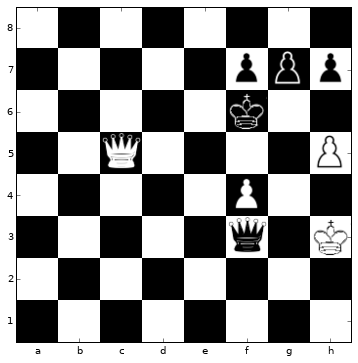

	h2h3 -0.0092851081863
WORST 5 Moves


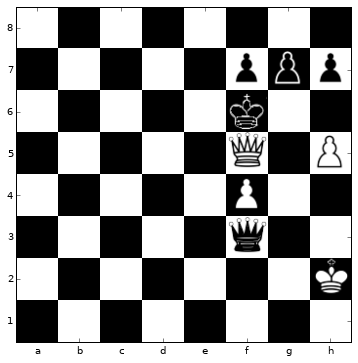

	c5f5 -0.0375707708299


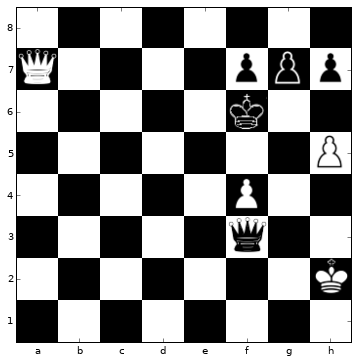

	c5a7 -0.0424057878554


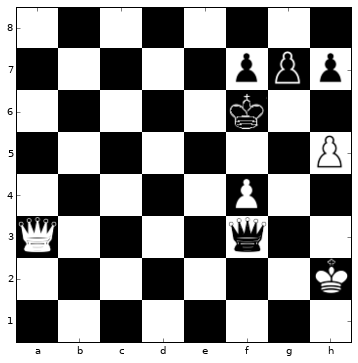

	c5a3 -0.0453675352037


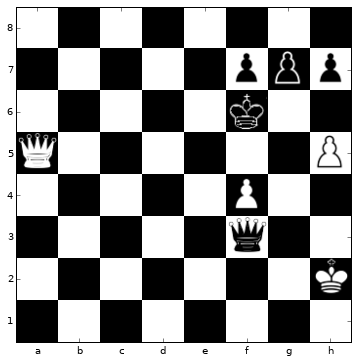

	c5a5 -0.0462996959686


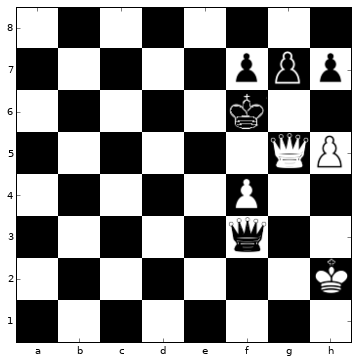

	c5g5 -0.0549010895193


In [28]:
'''
Mate in 1
'''
fen='8/5ppp/5k2/2Q4P/5P2/5q2/7K/8 w - - 0 0'
top_bottom_moves(fen)

In [82]:
fen='8/5ppp/5k2/2Q4P/5P2/5q2/7K/8 w - - 0 0'
pos = parseFEN(fen)
print pos.board
print evaluator.evaluate(np.rollaxis(convert_bitboard_to_image(pos.board), 2, 0))
move= "c5e5"
crdn = (sunfish.parse(move[0:2]), sunfish.parse(move[2:4]))
print pos.move(crdn).rotate().board
print evaluator.evaluate(np.rollaxis(convert_bitboard_to_image(pos.move(crdn).rotate().board), 2, 0))
print pos.move(crdn).board
print evaluator.evaluate(np.rollaxis(convert_bitboard_to_image(pos.move(crdn).board), 2, 0))


                   
 ........
 .....ppp
 .....k..
 ..Q....P
 .....P..
 .....q..
 .......K
 ........ 
                   
-0.00744872912765
                   
 ........
 .....ppp
 .....k..
 ....Q..P
 .....P..
 .....q..
 .......K
 ........ 
                   
-0.00996613316238
                   
 ........ 
k....... 
..Q..... 
..p..... 
p..q.... 
..K..... 
PPP..... 
........ 
                   
0.0228522643447


In [102]:
import h5py as h5
y = h5.File("/data/ConvChess/data/all_data_g07_pb_h5/piece.h5")
y = y['label']

In [103]:
y = y[0:1000000]
print np.std(y)
print np.var(y)

0.200632
0.0402531


In [81]:
evaluator = CNN_evaluator('regression_models/model_cvc_g09_10epochs.pkl')

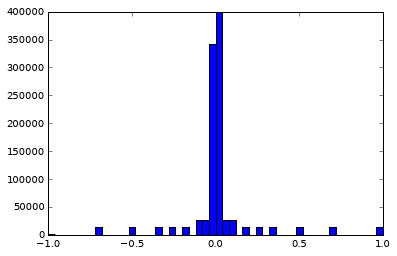

In [104]:
%matplotlib inline
import matplotlib.cm as cm
plt.hist(y, bins=50)
plt.show()